In [2]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.data.utils import save_matplotlib_fig
import pandas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

In [4]:
#directory preferences
PROJECT_ROOT= "."
IMAGE_SAVE_PATH = "images"

### Make Get DataSet
Getting the Moons dataset from sklearn and make dataset

In [5]:
from sklearn.datasets import make_moons
x,y  = make_moons(n_samples=10000,noise=0.4)

First, try to make sense of this data, with some charts/ stats

In [6]:
frame =pd.DataFrame(data=np.c_[x,y],columns =["X1","X2","Y"])
frame.describe()

X1            X2             Y
count  10000.000000  10000.000000  10000.000000
mean       0.504596      0.247833      0.500000
std        0.951356      0.632287      0.500025
min       -2.386711     -1.667158      0.000000
25%       -0.183312     -0.211749      0.000000
50%        0.517442      0.235856      0.500000
75%        1.185141      0.707281      1.000000
max        3.308359      2.225215      1.000000

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2)

Lets try to visualize the dataset using the first 200 samples

In [100]:
x_sample = X_train[:199,:]; y_sample=Y_train[:199] 

Simply drawing $X$ vs $Y$ wont really help us, we can use the fact that $Y$=0 or $Y$=1 (Graph will look something like (___-------) to separate the $X$s. And since we have only 2 features, we can plot a simple 2d graph

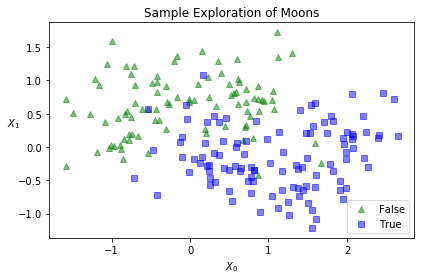

In [101]:
# find all X[:,0] where y==0 and X[:,1] where y==0 
#and plot them against each other. Do the same for X[:,1]
plt.plot(x_sample[:,0][y_sample==0],x_sample[:,1][y_sample==0],"g^",alpha=0.5,label="False")
plt.plot(x_sample[:,0][y_sample==1],x_sample[:,1][y_sample==1],"bs",alpha=0.5,label="True")
plt.legend(loc="lower right");
plt.title("Sample Exploration of Moons");
plt.xlabel("$X_0$");
plt.ylabel("$X_1$",rotation=0);
save_matplotlib_fig(PROJECT_ROOT,IMAGE_SAVE_PATH,"Sample_Moons")


### Training the classifier

I can see a non linear pattern here, the challange is trying to capture it via Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

#train Naive tree
naive_tree= DecisionTreeClassifier(max_depth=10)
naive_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Look at the image generated by the graph

Oh my god, Look at the number of nodes/leaves in graph. The decision boundary would be basically a giant over-fit over the data


In [27]:
from sklearn.tree import export_graphviz
import pydotplus
import pydotplus
from IPython.display import Image,display
naive_graph=export_graphviz(
        naive_tree,
        #out_file=os.path.join(PROJECT_ROOT,IMAGE_SAVE_PATH,"naive_tree_graph"),
        out_file=None,
        feature_names=["$X_0$","$X_1$"],
        class_names=["True","False"],
    filled=True,
    rounded=True
        
    )

Image(pydotplus.graph_from_dot_data(naive_graph).create_png(),height=500)


Try to prune the Tree and retry

In [45]:
first_pass_tree = DecisionTreeClassifier(max_leaf_nodes=5,max_depth=3)
first_pass_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=5, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Looks better, although looks like $X_0$ has many decision points and $X_1$ has fewer, If we look at the cart above, that intuitively makes sense. Lets test its accuracy and tune hyperparameters

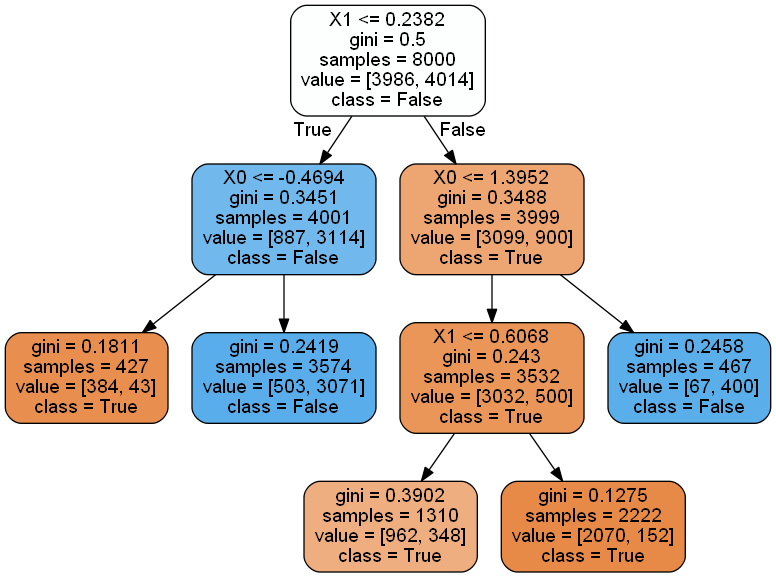

In [99]:
first_pass=export_graphviz(
        first_pass_tree,
        
        out_file=None,
        feature_names=["X0","X1"],
        class_names=["True","False"],
    filled=True,
    rounded=True
    
        
    )
Image(pydotplus.graph_from_dot_data(first_pass).create_png(),height=300)

In [74]:
from sklearn.metrics import accuracy_score
y_pred = first_pass_tree.predict(X_test)
print('Accuracy={:.2f}%'.format(accuracy_score(y_pred=y_pred,y_true=Y_test)*100))

Accuracy =85.00%


In [80]:
from sklearn.model_selection import GridSearchCV
params = {'max_leaf_nodes':range(2,10),'max_depth':range(1,5)}
clf = GridSearchCV(first_pass_tree,params,cv=5,verbose=1)
clf.fit(X_train,Y_train)
clf.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.8s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=4, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Looks like we hit our ceiling on the Classifier

In [82]:
best_est = clf.best_estimator_
y_pred = best_est.predict(X_test)
print('Accuracy={:.2f}%'.format(accuracy_score(y_pred=y_pred,y_true=Y_test)*100))


Accuracy=85.00%


#### Lets update our original plot to show decision boundaries that the predictor provides

In [83]:
x_sample = X_test[:199,:]; y_sample=Y_test[:199] 

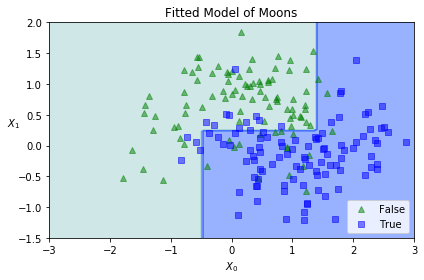

In [98]:
from matplotlib.colors import ListedColormap
x1 = np.linspace(-3,3,100)
x2 = np.linspace(-1.5,2,100)
x_1,x_2 = np.meshgrid(x1,x2)
X_new = np.c_[x_1.ravel(), x_2.ravel()]
y_pred = best_est.predict(X_new).reshape(x_1.shape)
custom_cmap = ListedColormap(['#a1d0d0','#3366ff'])
plt.contourf(x_1, x_2, y_pred, alpha=0.5, cmap=custom_cmap)
plt.plot(x_sample[:,0][y_sample==0],x_sample[:,1][y_sample==0],"g^",alpha=0.5,label="False")
plt.plot(x_sample[:,0][y_sample==1],x_sample[:,1][y_sample==1],"bs",alpha=0.5,label="True")
plt.legend(loc="lower right");
plt.title("Fitted Model of Moons");
plt.xlabel("$X_0$");
plt.ylabel("$X_1$",rotation=0);
save_matplotlib_fig(PROJECT_ROOT,IMAGE_SAVE_PATH,"Fitted_Moons")